<a href="https://colab.research.google.com/github/logansmith9454/cse450/blob/main/notebooks/starter_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install scikit-learn==1.5.2

In [14]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt


housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

cat_cols = ['waterfront', 'view', 'condition', 'grade', 'zipcode']
num_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
          'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
          'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_year', 'sale_month']

def transform_data(df, train_cols=None):
  # Add sale_year and sale_month columns
  df['sale_year'] = pd.to_datetime(df['date']).dt.year
  df['sale_month'] = pd.to_datetime(df['date']).dt.month

  df = df.drop(['date'], axis=1)

  if 'price' in df.columns:
      X = pd.get_dummies(df.drop('price', axis=1), columns=cat_cols)
      y = df['price']
  else:
      X = pd.get_dummies(df, columns=cat_cols)
      y = None

  if train_cols is not None:
      X = X.reindex(columns=train_cols, fill_value=0)


  return X, y, X.columns.tolist()


X, y, train_cols = transform_data(housing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = xgb.XGBRegressor(enable_categorical=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: ${rmse:,.2f}")
print(f"R^2: {r2:.1%}")

RMSE: $128,803.56
R^2: 88.9%


In [4]:
from sklearn.model_selection import GridSearchCV

# Define expanded parameter grid for XGBoost
param_grid = {
    'regressor__n_estimators': [250, 500, 750],
    'regressor__learning_rate': [0.05, 0.1, 0.15],
    'regressor__max_depth': [2, 3, 4],
    'regressor__subsample': [0.6, 0.7],
    'regressor__colsample_bytree': [0.6, 0.7]
}

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=model,  # Your existing pipeline
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Optimize for MSE
    n_jobs=-1  # Use all CPU cores
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Print best parameters
print(f'Best Parameters: {grid_search.best_params_}')

KeyboardInterrupt: 

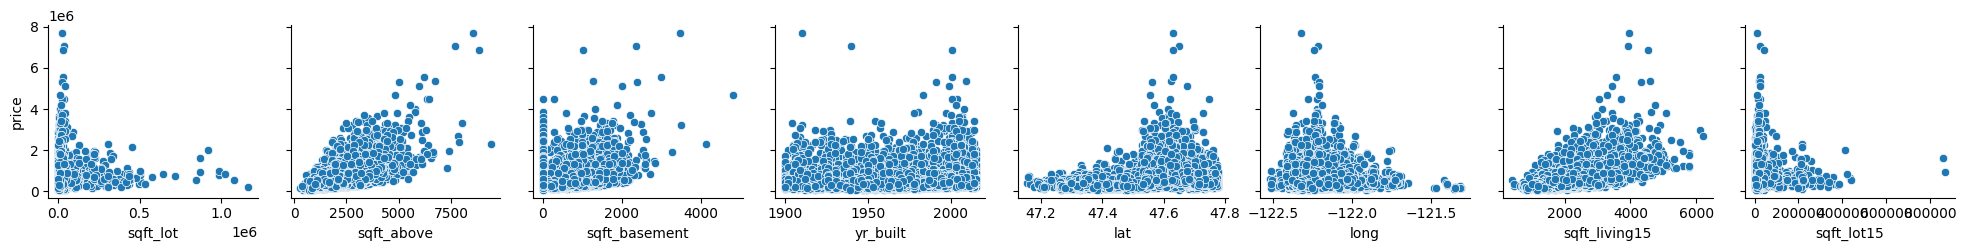

In [22]:
cont_cols = ["sqft_lot", "sqft_above", "sqft_basement", "yr_built", "lat", "long", "sqft_living15", "sqft_lot15"]
sns.pairplot(data = housing, x_vars = cont_cols, y_vars = 'price')

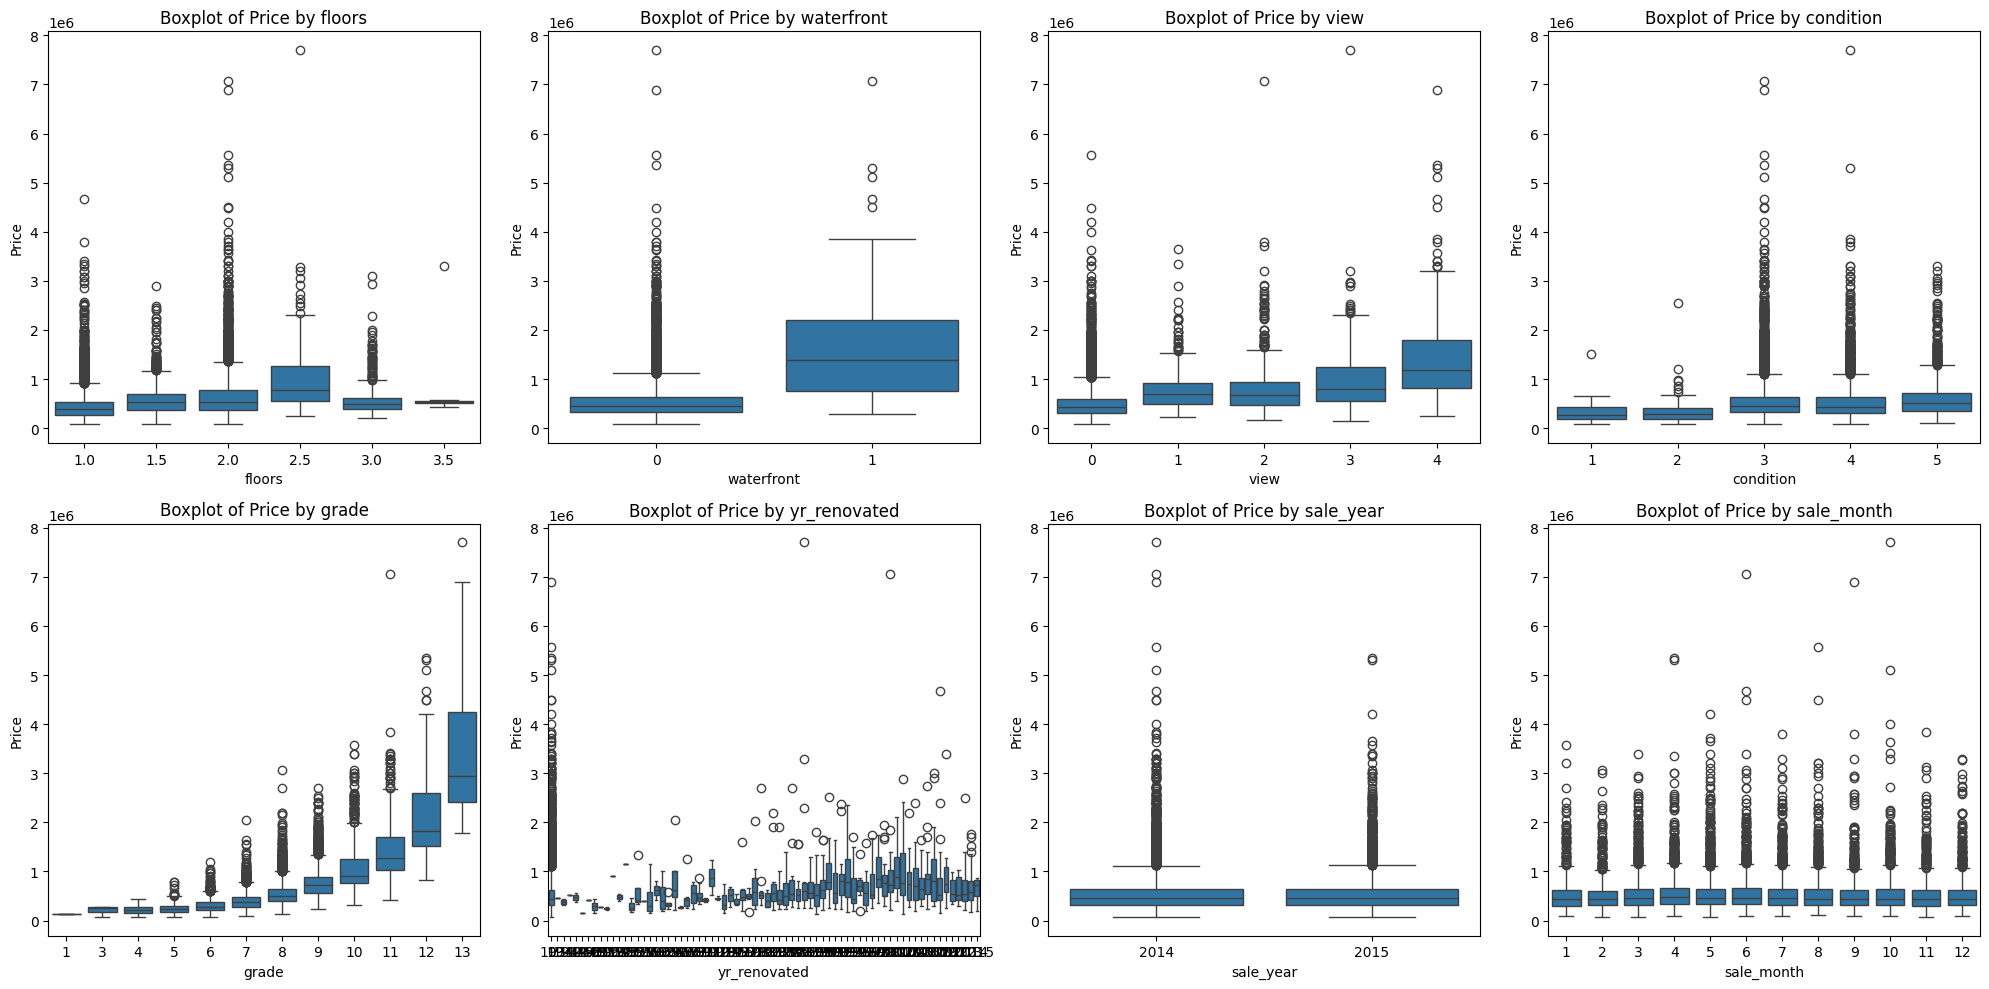

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Columns that are more discrete or categorical
cont_cols = ["floors", "waterfront", "view", "condition", "grade", "yr_renovated", "sale_year", "sale_month"]

# Create individual boxplots for each discrete column against price with independent y-axes
n_cols = 4 # Number of columns for the grid
n_rows = (len(cont_cols) + n_cols - 1) // n_cols # Calculate number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5)) # Adjust figure size as needed
axes = axes.flatten() # Flatten the axes array for easier iteration

for i, col in enumerate(cont_cols):
    sns.boxplot(data=housing, x=col, y='price', ax=axes[i])
    axes[i].set_title(f'Boxplot of Price by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [ ]:
mini_holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')

mini_X, _, _ = transform_data(mini_holdout, train_cols=train_cols) # Get only the features, y will be None

mini_y_pred = model.predict(mini_X)

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(mini_y_pred, columns=['price'])

# Save the DataFrame to a CSV file
# file_name = 'v2-team1-module3-predictions.csv'
# predictions_df.to_csv(file_name, index=False)
# files.download(file_name)

In [ ]:
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')

X, _, _ = transform_data(holdout, train_cols=train_cols)

y_pred = model.predict(X)

predictions_df = pd.DataFrame(y_pred, columns=['price'])

print(f"{len(holdout)=}")
print(f"{len(predictions_df)=}")

# Save the DataFrame to a CSV file
# file_name = 'v2-team1-module3-predictions.csv'
# predictions_df.to_csv(file_name, index=False)
# files.download(file_name)